# Линейная регрессия с `statsmodels` и `seaborn`

### Дружинина Анжелика

Установим библиотеку `seaborn`:

In [ ]:
!pip install seaborn

Импортируем эту библиотеку:

In [ ]:
import seaborn as sns

Импортируем остальные библиотеки и модули для работы: `pandas` для работы с датафреймом и `pyplot` для базовых графиков:

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

Загрузим данные из CSV-файла по ссылке:

In [ ]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Salaries.csv")

Посмотрим на первые несколько строк датафрейма:

In [ ]:
df.head()

,Unnamed: 0,rank,discipline,yrs.since.phd,yrs.service,sex,salary
0,1,Prof,B,19,18,Male,139750
1,2,Prof,B,20,16,Male,173200
2,3,AsstProf,B,4,3,Male,79750
3,4,Prof,B,45,39,Male,115000
4,5,Prof,B,40,41,Male,141500


В этом файле сохранены данные по сотрудникам университета в США, а именно следующие их характеристики:

* `rank`: должность;
* `discipline`: тип преподаваемой дисциплины (`A` – теоретическая, `B` – практическая);
* `yrs.since.phd`: число лет с момента получения степени PhD;
* `yrs.service`: число лет опыта работы;
* `sex`: пол;
* `salary`: заработная плата за 9 месяцев, в долларах.

Для удобства дальнейшей работы переименуем столбцы с длинными названиями: вместо `yrs.since.phd` запишем просто `phd`, а вместо `yrs.service` — `service`. Для этого понадобится метод `.rename()` для датафреймов:

In [ ]:
df.rename(columns = {"yrs.since.phd" : "phd", "yrs.service" : "service"},  inplace = True)

Метод `.rename()` по умолчанию работает не со столбцами, а со строками, поэтому, чтобы переименование применялось именно к столбцам, указываем название аргумента `columns`, внутри которого помещаем словарь с парами *старое название-новое название*. Метод `.rename()` возвращает измененную копию таблицы, но не вносит изменения в сам датафрейм. Поэтому, чтобы сохранить изменения дописываем аргумент `inplace = True`, который заменяет названия прямо в исходном датафрейме. В общем, строка выше эквивалентна обычному присваиванию через `=` :

    df = df.rename(columns = {"yrs.since.phd" : "phd", "yrs.service" : "service"})

Прежде чем приступить к построению регрессионных моделей, которые покажут взаимосвязь между заработной платой сотрудников и их характеристиками, посмотрим на их распределение. Построим гистограмму для заработной платы, для столбца `salary`:

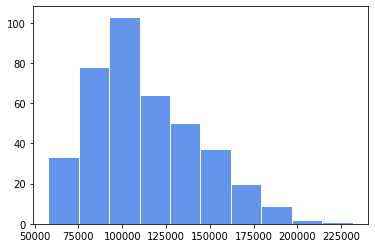

In [ ]:
plt.hist(df["salary"], color = "cornflowerblue", edgecolor = "white");

Проинтерпретируем полученный график. Распределение заработной платы не является симметричным, оно немного скошено вправо – в выборке есть несколько сотрудников с нетипично высокой заработной платой (200 тысяч долларов и выше). Больше всего сотрудников с заработной платой около 100 тысяч долларов. Небольшую скошенность распределения можно заметить и по описательным статистикам:

In [ ]:
df["salary"].describe()

count       397.000000
mean     113706.458438
std       30289.038695
min       57800.000000
25%       91000.000000
50%      107300.000000
75%      134185.000000
max      231545.000000
Name: salary, dtype: float64

Среднее выборки равно 113706 долларов, а медиана чуть меньше, 107300 долларов. Среднее здесь немного «завышено», как раз из-за наличия сотрудников с нетипично высокой заработной платой. Отсюда и скошенность – распределение симметрично, если среднее и медиана совпадают. 

Теперь построим гистограмму для стажа, числа лет опыта работы:

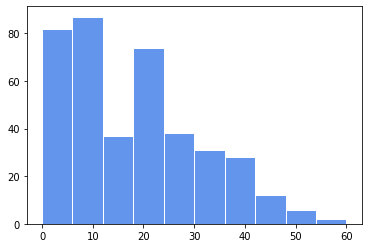

In [ ]:
plt.hist(df["service"], color = "cornflowerblue", edgecolor = "white");

Тоже имеет место скошенность вправо, при этом большая часть значений сосредоточена в интервале от 0 до 10 (примерно). То есть, довольно много сотрудников с относительно небольшим опытом работы, не более 10 лет.

### Изучение взаимосвязи: диаграммы рассеивания и корреляция

Приступим к изучению взаимосвязи между опытом работы и заработной платой. Начнем с диаграммы рассеивания, только построим ее не с помощью `matplotlib`, а с помощью `seaborn`. Сначала настроим общую тему графиков – чтобы на них присутствовала сетка, а фон при этом был белым:

In [ ]:
sns.set_theme(style = "whitegrid")

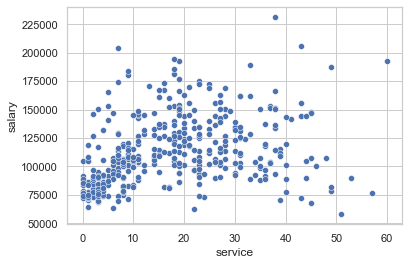

In [ ]:
sns.scatterplot(data = df, x = "service", y = "salary");

В `data` указываем название датафрейма, столбцы из которого мы используем для построения графика, а затем в `x` и `y` перечисляем сами названия этих столбцов.

На диаграмме рассеивания мы видим, что связь между числом лет опыта работы и заработной платы есть, но не то чтобы линейная. В целом, если стаж сотрудников меньше 30 лет, связь между опытом работы и заработной платы прямая (чем больше опыта, тем выше зарплата), а если стаж выше – связь обратная (чем больше опыта, тем ниже зарплата). Это вполне объяснимо: опыт работы естественным образом связан с возрастом, а с определенного возраста заработная плата может становиться ниже в силу разных причин (меньшая активность, неготовность обучаться новым технологиям, состояние здоровья и прочее).

Действительно, если мы вычислим коэффициент корреляции Пирсона между этими показателями, который показывает линейную связь, он будет невысоким:

In [ ]:
df[["salary", "service"]].corr()  # 0.33

,salary,service
salary,1.000000,0.334745
service,0.334745,1.000000


Можем дополнительно сгруппировать точки в зависимости от должности (`rank`) и учесть это на графике:

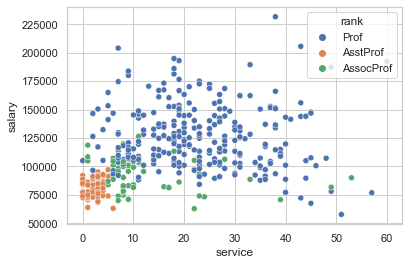

In [ ]:
sns.scatterplot(data = df, x = "service", y = "salary", hue = "rank");  

Можно заметить, что характер связи между числом лет опыта работы и заработной платой примерно одинаковый у преподавателей (*assistant professor*) и доцентов (*associate professor*), увеличение стажа сопровождается увеличением заработной платы. А вот у профессоров ситуация более разнообразная: их больше, и у кого-то связь между стажем и заработной платой прямая, а у кого-то – обратная. 


### Парная регрессия и множественная регрессия

Теперь приступим к построению линейных регрессионных моделей. Для этого нам понадобится функция `ols` из модуля внутри библиотеки `statsmodels`. 

In [ ]:
from statsmodels.formula.api import ols

Теперь построим модель парной линейной регрессии, которая покажет, каким образом заработная плата зависит от стажа:

$$
\widehat{salary}_i = \hat{b}_0 + \hat{b}_1 \times service_i.
$$

Запишем внутри функции `ols()` формулу вида `y ~ x`, где `y` – зависимая переменная, а `x` – независимая переменная, а затем укажем название датафрейма, откуда брать эти переменные `y` и `x`:

In [ ]:
ols("salary ~ service", df)

Python создал объект «линейная модель, оцененная методом наименьших квадратов», но пока ее не оценил, то есть не вычислил коэффициенты $\hat{b}_0$ и $\hat{b}_1$. Чтобы он это сделал, нужно применить к этой модели метод `.fit()`:

In [ ]:
model = ols("salary ~ service", df).fit() 

Модель получена, выведем подробную выдачу с результатами, применив метод `.summary()`:

In [ ]:
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     49.85
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           7.53e-12
Time:                        15:49:22   Log-Likelihood:                -4635.7
No. Observations:                 397   AIC:                             9275.
Df Residuals:                     395   BIC:                             9283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.997e+04   2416.605     41.370      0.0

В первой части выдачи сохранена сводная информация по модели. Из самого актуального пока здесь только число наблюдений (`No.observations`), коэффициент детерминации $R^2$ (`R-squared`) и его скорректированная версия (`Adj. R-squared`). Можем сказать, что наша модель объясняет примерно 11% изменчивости заработной платы сотрудников, это не очень много, но вполне объяснимо. Во-первых, странно ожидать, что кроме опыта работа на заработную плату ничего не влияет, а во-вторых, ранее отмечалось, что связь между этими показателями не совсем линейная. Изучим линейную модель, так как она проста и удобна для интерпретации.

Перейдем к основной части выдачи – коэффициентам. Используя значения из столбца `coef`, мы можем записать уравнение модели. Здесь `Intercept` – это константа $\hat{b}_0$, а `service` – коэффициент $\hat{b}_1$ при независимой переменной `service`:

$$
\widehat{salary}_i =  99970 +  779.5691 \times service_i.
$$

Проинтерпретируем полученные результаты. Значение `Intercept` – это среднее значение зависимой переменной в случае, если значение независимой равно 0. В данном случае это среднее значение заработной платы (в долларах, за 9 месяцев), которое может ожидать сотрудник без опыта работы ($\text{service} = 0$). Коэффициент при `service`, чисто математически, показывает, на сколько, в среднем, изменяется значение `salary` при увеличении `service` на 1. Однако в реальной жизни, если мы не имеем дело с контролируемым экспериментом, такая интерпретация не всегда корректна, так как она намекает на причинно-следственную связь. Мы не можем остановить или ускорить время, чтобы влиять на число лет опыта сотрудников и изучать, как его изменение отражается на заработной плате (и при этом гарантировать, что другие факторы, не включенные в модель, не изменяются). Поэтому поступим так: скажем, что у тех сотрудников, у которых стаж выше на 1 год, заработная плата, в среднем, выше на 779.57 долларов.

Теперь проверим, а можно ли считать связь между опытом работы и заработной платой статистически значимой. В рамках модели это означает, что мы должны проверить гипотезу о равенстве истинного значения коэффициента $b_1$ нулю:

$$
H_0: b_1 = 0
$$

Посмотрим на p-value, полученное в результате проверки этой гипотезы. Оно находится в столбце `P>|t|`, так как по определению это:

$$
\text{P}(|T| > |t|) = \text{P}(|T| > 7.060) = \text{P}(T > 7.060) + \text{P}(T < -7.060),
$$

где $T$ – случайная величина, имеющая распределение Стьюдента с $n-2$ степенями свободы.

Здесь p-value равно 0, поэтому гипотезу о равенстве истинного значения коэффициента при `service` мы отвергаем на любом разумном уровне значимости (оно меньше 0.05 и 0.01 тоже). Значит, связь между показателями есть, изменение числа лет опыта работы сказывается на заработной плате. 

Коэффициенты модели можно также запросить отдельно, извлечь их из объекта `model` как атрибут:

In [ ]:
print(model.params)

Intercept    99974.652866
service        779.569114
dtype: float64


С таким же успехом можно извлечь и другие характеристики модели, например, коэффициент детерминации $R^2$:

In [ ]:
print(model.rsquared)

0.11205399790940596


Выше получено уравнение модели:
    
$$
\widehat{salary}_i =  99970 +  779.5691 \times service_i.
$$

Это уравнение можно использовать для предсказания заработной платы на основании стажа. Мы можем подставить вместо `service` любое число лет опыта работы и получить ожидаемое, согласно нашей модели, значение заработной платы. 

Если мы хотим использовать модель для предсказания на основе каких-то своих значений, например, тех, которых в датафрейме нет, их можно записывать в виде словаря и помещать его в аргумент `exog` (от *exogeneous*, внешние данные):

In [ ]:
# значение заработной платы для человека с 30-летним стажем

model.predict(exog = {"service" : 30})

0    123361.726277
dtype: float64

Если значений несколько, их оформляем в виде списка:

In [ ]:
# значение заработной платы для человека с 30-летним и 50-летним стажем

model.predict(exog = {"service" : [30, 50]})

0    123361.726277
1    138953.108551
dtype: float64

Теперь, используя `seaborn`, построим диаграмму рассеивания с добавленной на нее регрессионной прямой. Для этого нам понадобится специальная функция `lmplot()`:

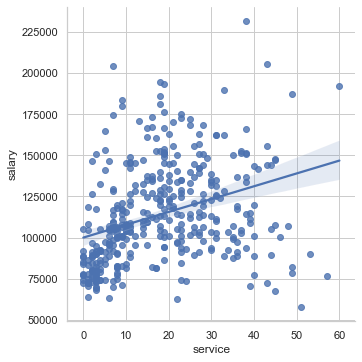

In [ ]:
sns.lmplot(data = df, x = "service", y = "salary");

График получился вполне наглядным, построена регрессионная прямая с добавленным 95%-ным доверительным интервалом для нее (закрашенный «коридор» вокруг прямой, который показывает, где с 95%-ной уверенностью эта прямая может лежать, если мы учтем, что регрессию можно строить и на других выборках, на которых значения оценок коэффициентов $\hat{b}_0$ и $\hat{b}_1$, определяющих вид и наклон прямой, будут другими).

Посмотрим, как выглядит взаимосвязь между стажем и заработной платой, отдельно для сотрудников мужского и женского пола:

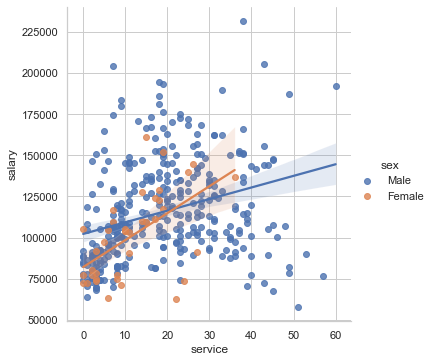

In [ ]:
# добавляем цвет hue в зависимости от пола sex

sns.lmplot(data = df, x = "service", y = "salary", hue = "sex");

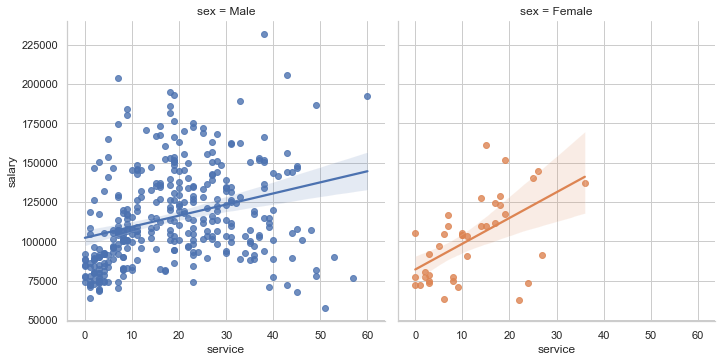

In [ ]:
# можем разбить на отдельные графики – столбцы col, для наглядности

sns.lmplot(data = df, x = "service", y = "salary", hue = "sex", col = "sex");

На этих графиках изображены регрессионные прямые `salary ~ service` для каждой группы наблюдений, для каждого значения пола отдельно. Здесь можно заметить довольно интересную особенность: средняя заработная плата женщин ниже (оранжевая прямая пересекает вертикальную ось ниже, чем синяя), но при этом с увеличением стажа она увеличивается быстрее (оранжевая прямая более крутая, имеет более сильный наклон). Это можно воспринимать как сигнал, что в последующих более сложных регрессионных моделях стоит учесть не только то, что заработная плата связана с опытом работы и полом сотрудника, но и то, что характер связи неодинаков у мужчин и женщин. 
Теперь построим обычную модель множественной регрессии с двумя независимыми переменными, стаж (`service`) и пол (`sex`):

In [1]:
model2 = ols("salary ~ service + sex", df).fit()

NameError: ignored

In [ ]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     26.82
Date:                Sat, 08 Oct 2022   Prob (F-statistic):           1.20e-11
Time:                        15:49:24   Log-Likelihood:                -4633.9
No. Observations:                 397   AIC:                             9274.
Df Residuals:                     394   BIC:                             9286.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.236e+04   4740.188     19.484      



Проинтерпретируем коэффициенты (судя по p-value, они все значимы, правда, коэффициент при `sex` только на 10%-ном уровне значимости): 

* Среднее значение заработной платы за 9 месяцев для сотрудников без опыта работы (`service = 0`) женского пола (`Male = 0`) равно 92360 долларов.

* При прочих равных условиях, у сотрудников, чей стаж на 1 год больше, заработная плата, в среднем, выше на 747.61 долларов. То есть, если мы сравним двух коллег одного и того же пола (смысл «при прочих равных» для данного случая), в среднем, заработная плата того, кто работает на год больше, будет выше на 747.61 долларов.

* При прочих равных условиях, средняя заработная плата мужчин выше средней заработной платы женщин на 9071.8 долларов. То есть, если мы сравним двух коллег с одинаковым стажем, но разного пола, в среднем, зарплата коллеги мужского пола будет выше на 9071.8 долларов (смысл коэффициента при `sex[T.Male]` с учетом уточнения «при прочих равных»). 